In [5]:
import sys
print(sys.executable)

/opt/homebrew/Caskroom/miniconda/base/bin/python


In [ ]:
import os
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from pickle import dump, load

from imblearn.over_sampling import SMOTE


In [7]:
# Define function to load images from a specific folder
def load_images_from_folder(folder):
    X, y = [], []
    
    for subdir, dirs, files in os.walk(folder):
        label = os.path.basename(subdir)  
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(subdir, file)
                
                # Load, convert to grayscale, and resize to (48, 48)
                image = Image.open(img_path).convert('L')
                image = image.resize((48, 48))
                
                X.append(np.array(image).flatten())
                y.append(label)
    
    return np.array(X), np.array(y)

# Define paths for train and validation folders
train_folder = '/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/images/train'
val_folder = '/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/images/validation'

# Load training data
X_train, y_train = load_images_from_folder(train_folder)
X_val, y_val = load_images_from_folder(val_folder)

print(f"Training samples: {len(X_train)} | Validation samples: {len(X_val)}")

# (Optional) Save datasets as a pickle file
dataset_file = "dataset_dump.pkl"
with open(dataset_file, "wb") as f:
    dump((X_train, y_train, X_val, y_val), f, protocol=5)


Training samples: 28821 | Validation samples: 7066


In [ ]:
# with open("dataset_dump.pkl", "rb") as f:
#     X_original,X,y = load(f)

In [9]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train
y_train

X_test = np.array(X_val)
y_test = np.array(y_val)

X_test
y_test

array(['happy', 'happy', 'happy', ..., 'disgust', 'disgust', 'disgust'],
      dtype='<U8')

In [10]:
def preprocessing_data(X_train, y_train, X_test, y_test, save_file_to=None):
    # Normalize pixel values
    X_train = X_train / 255.0
    X_test = X_test / 255.0  

    # Encode labels (consistent encoding across train and val)
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Dimensionality reduction with PCA (whitening to decorrelate)
    pca = PCA(n_components=100, whiten=True, random_state=42)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # Standardize the data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_reduced)
    X_test_scaled = scaler.transform(X_test_reduced)

    print("Training set shape:", X_train_scaled.shape)
    print("Validation set shape:", X_test_scaled.shape)

    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, label_encoder, scaler), f, protocol=5)

    return X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, label_encoder, scaler

# Preprocess data
preprocessed_file = "improved_preprocessed_data.pkl"
X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, label_encoder, scaler = preprocessing_data(X_train, y_train, X_test, y_test, save_file_to=preprocessed_file)


Training set shape: (28821, 100)
Validation set shape: (7066, 100)


In [11]:
X_train_scaled[0]

array([-0.27987914,  0.75770443, -0.40102151,  0.73228184, -0.03639196,
        0.21701119,  0.25773299, -0.61532569, -0.22637203, -0.68197558,
       -0.13467515,  0.9401195 ,  0.26837558,  0.2511649 ,  0.32325188,
       -0.5032972 ,  0.34752576,  0.50337178,  0.738955  ,  0.02834628,
        0.52177831, -0.9009628 ,  0.41131757,  0.27067599,  0.23711481,
       -0.12234235, -0.24679569, -0.02597552, -0.76724663, -0.35655215,
       -0.76766621, -1.06039431, -0.06938228,  0.20870829, -0.0995933 ,
        0.26654708,  0.3232688 , -0.19262272,  0.17010821, -0.87303109,
       -1.22282895, -0.11042818,  0.25465741, -0.40040574,  0.04368521,
       -0.22951116, -0.49462149, -0.56524857, -0.73851583,  1.0665183 ,
        0.21043441, -0.52871835, -0.23718798,  0.44191737,  0.41513935,
        0.78887316,  0.10052073,  0.76160815, -0.92258178, -0.10614413,
       -0.63950286,  0.14123229,  0.43753652,  0.24509247,  0.31567851,
        0.33305051, -0.91984507,  0.62107995, -0.11031021, -0.42

In [17]:

# Handle class imbalance
def handle_class_imbalance(X_train, y_train):
    # Check class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print("Class distribution before balancing:", class_dist)
    
    # Only apply SMOTE if imbalanced
    if max(counts) / min(counts) > 1.5:  # Threshold for imbalance
        print("Detected class imbalance, applying SMOTE...")
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
        unique_after, counts_after = np.unique(y_resampled, return_counts=True)
        print("Class distribution after balancing:", dict(zip(unique_after, counts_after)))
        return X_resampled, y_resampled
    
    print("No significant class imbalance detected.")
    return X_train, y_train

X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_scaled, y_train_encoded)

Class distribution before balancing: {0: 3993, 1: 436, 2: 4103, 3: 7164, 4: 4982, 5: 4938, 6: 3205}
Detected class imbalance, applying SMOTE...
Class distribution after balancing: {0: 7164, 1: 7164, 2: 7164, 3: 7164, 4: 7164, 5: 7164, 6: 7164}


In [18]:

# Feature selection
def select_features(X_train, X_test, y_train, k=None):
    if k is None:
        k = min(200, X_train.shape[1])  # Default: select top 200 features or less
    else:
        k = min(k, X_train.shape[1])  # Ensure k doesn't exceed available features
        
    print(f"Selecting top {k} features...")
    
    # Use f_classif which works for any input values (unlike chi2 which requires non-negative)
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    print(f"Features reduced from {X_train.shape[1]} to {X_train_selected.shape[1]}")
    return X_train_selected, X_test_selected, selector

X_train_selected, X_test_selected, selector = select_features(X_train_balanced, X_test_scaled, y_train_balanced)


Selecting top 100 features...
Features reduced from 100 to 100


In [21]:
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, label_encoder):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'p': [1, 2]
    }

    best_combination = None
    best_accuracy = 0
    
    # Convert class names to strings if they're not already
    class_names = [str(name) for name in label_encoder.classes_]

    all_combinations = list(ParameterGrid(param_grid))
    for combination in all_combinations:
        print(combination)
        knn_model = KNeighborsClassifier(**combination)  # No random_state for KNN
        knn_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = knn_model.predict(X_test)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = combination
    
    # Print the best combination
    print("\nBest Combination:", best_combination)
    print(f"Best Accuracy: {best_accuracy:.2f}")
    print("\nTotal combinations:", len(all_combinations))

    # Train the best model on the entire training set
    best_model = KNeighborsClassifier(**best_combination)
    best_model.fit(X_train, y_train)

    # Save the best model
    with open("knn_model_standardscaler_gridsearch_pca_dump.pkl", "wb") as f:
        dump(best_model, f, protocol=5)
    print("Best model saved successfully!")

    return best_model, best_combination
best_model, best_combination = train_and_evaluate_knn(X_train_selected, y_train_balanced, X_test_selected, y_test_encoded, label_encoder)


{'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.31
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.37      0.32       960
           1       0.10      0.66      0.17       111
           2       0.28      0.38      0.32      1018
           3       0.60      0.13      0.21      1825
           4       0.28      0.37      0.32      1216
           5       0.34      0.24      0.28      1139
           6       0.52      0.55      0.53       797

    accuracy                           0.31      7066
   macro avg       0.34      0.38      0.31      7066
weighted avg       0.40      0.31      0.31      7066

{'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.35
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.32      0.33       960
           1       0.11      0.63      0.19       111
           2       

In [ ]:

# Evaluate the model
def evaluate_model(model, X_test, y_test, label_encoder):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return y_pred, accuracy

y_pred, accuracy = evaluate_model(best_model, X_test_selected, y_test, label_encoder)



Model Evaluation:
Accuracy: 0.3885

Classification Report:
              precision    recall  f1-score   support

       angry       0.40      0.27      0.32      1010
     disgust       0.30      0.47      0.37       105
        fear       0.40      0.37      0.38      1065
       happy       0.49      0.41      0.44      1766
     neutral       0.26      0.44      0.33      1212
         sad       0.33      0.30      0.32      1214
    surprise       0.61      0.57      0.59       806

    accuracy                           0.39      7178
   macro avg       0.40      0.40      0.39      7178
weighted avg       0.41      0.39      0.39      7178



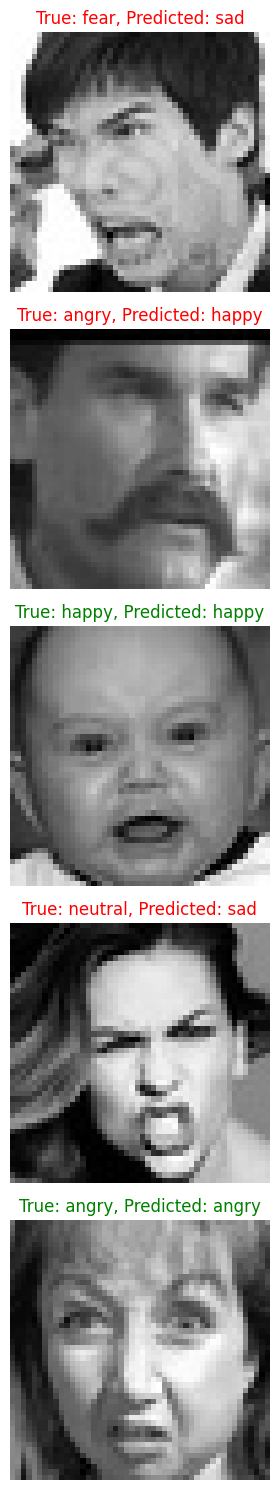

In [ ]:
def visualize_predictions(best_model, X_test_selected, y_test_encoded, label_encoder, X_test_original):
    # Make predictions on the transformed/selected test data
    y_pred = best_model.predict(X_test_selected)
    
    # Choose random indices to visualize
    random_indices = np.random.randint(0, len(y_test_encoded), 5)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, 5, i+1)
        
        # Reshape the original image (48x48 from your resize operation)
        original_image = X_test_original[idx].reshape(48, 48)
        
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test_encoded[idx]])[0]}\n"
                  f"Pred: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with the proper variables
# You need the original test images before preprocessing
X_test_original = X_test * 255.0  # Convert back from normalized values if necessary

visualize_predictions(best_model, X_test_selected, y_test_encoded, label_encoder, X_test_original)


In [ ]:

# Save the final model
model_file = "improved_knn_model.pkl"
with open(model_file, "wb") as f:
    dump((best_model, pca, scaler, selector, label_encoder, best_params), f, protocol=5)
print(f"Model saved to {model_file}")

# To load and use the model later:
# with open(model_file, "rb") as f:
#     best_model, pca, scaler, selector, label_encoder, best_params = load(f)
#
# # For new data:
# def predict_new_image(image_path, model, pca, scaler, selector, label_encoder):
#     # Load and preprocess image
#     image = Image.open(image_path).convert('L')
#     image = image.resize((48, 48))
#     flat_image = np.array(image).flatten() / 255.0
#     
#     # Apply transformations
#     transformed = pca.transform([flat_image])
#     transformed = scaler.transform(transformed)
#     transformed = selector.transform(transformed)
#     
#     # Predict
#     prediction = model.predict(transformed)
#     label = label_encoder.inverse_transform(prediction)[0]
#     
#     return label

NameError: name 'pca' is not defined